In [31]:
# import packages
import numpy as np
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
%matplotlib inline

In [32]:
df = pd.read_csv('../data/raw/data.csv')
df.head()

,id,tweet_text,Label,Set,Unnamed: 4,r,pct,80
0,2,"@NFLfantasy @Akbar_Gbaja Damn right, Akbar.",neutral,s1,NaN,0.227180,42,s1
1,3,@NFLfantasy @Akbar_Gbaja I've got backup _‰гў‰Ы__,neutral,s1,NaN,0.531081,4,s1
2,5,"""No one is going to replace the production of ...",neutral,s1,NaN,0.546614,65,s1
3,7,@Sheikh__Akbar It's actually PERFECT for you m...,neutral,s1,NaN,0.228940,26,s1
4,10,Was Trump right? Officers say pockets of Musli...,neutral,s1,NaN,0.063069,19,s1


### Initial thoughts
Looking at this data we have a few issues. There is an unamed column and a meaningless "80" column from my conversion from xlsx to csv. The columns 'r' and 'pct' at a glance don't mean anything to me yet so will require further investigation.

First I want to clean up the data, I will drop these uneccesary columns and try to give the headings more meaningful labels.

In [33]:
# axis=1 allows us to drop columns instead of rows
df = df.drop(['id','Unnamed: 4', '80'], axis=1)

# then re-label the columns to something more consistent and meaningful
df.columns = ['text', 'label', 'set', 'r', 'percentage']
df.head()

,text,label,set,r,percentage
0,"@NFLfantasy @Akbar_Gbaja Damn right, Akbar.",neutral,s1,0.227180,42
1,@NFLfantasy @Akbar_Gbaja I've got backup _‰гў‰Ы__,neutral,s1,0.531081,4
2,"""No one is going to replace the production of ...",neutral,s1,0.546614,65
3,@Sheikh__Akbar It's actually PERFECT for you m...,neutral,s1,0.228940,26
4,Was Trump right? Officers say pockets of Musli...,neutral,s1,0.063069,19


### Tweet cleaning
For such a small dataset there are certain preparations we need to do before moving forward with tweet values. A good first step here is removing stop words( such as : and, then, a, i), however algorithms now deal with these themselves and now hold more value than previousy thought. To Do :
* replace mentions with a generic mention.
* replace links with a generic link.
* clear any redundant punctuation.

In [34]:
# using this test as to not disregard e-mail
# Regex from https://stackoverflow.com/questions/2304632/regex-for-twitter-username

test = '@Joe is really getting on my nerves, his e-mail joe@joe.com is cool'

def generalize_mentions(text):
    return re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)', '@twitterMention', text)

generalize_mentions(test)

'@twitterMention is really getting on my nerves, his e-mail joe@joe.com is cool'

In [35]:
# clean out urls
# regex from https://stackoverflow.com/questions/37807244/python-to-extract-the-user-and-url-link-in-twitter-text-data-with-regex
test = 'Another beautiful bike https://goo.gl/i86vtG'

def generalize_urls(text):
    return re.sub(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', 'urlRemoved', text)

generalize_urls(test)


'Another beautiful bike urlRemoved'

In [36]:
# clean out punctuation
# from https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python

test = '@joe he said "who are you?", wacky!'

def scrub_punctuation(text):
    return text.translate(None, string.punctuation)

scrub_punctuation(test)

'joe he said who are you wacky'

In [37]:
# read in slurs list
df_slurs = pd.read_csv('../data/raw/Terms-to-Block.csv', header=None, index_col=False)
slurs_list =  df_slurs.values[0]

In [38]:
# count slurs in tweets
def count_slurs(text):
    return len(set(text.split(' ')) & set(slurs_list))

In [39]:
# now lets apply all of these to text
# apply cleaning to dataset
df['text'] = df['text'].apply(generalize_mentions)
df['text'] = df['text'].apply(generalize_urls)
df['text'] = df['text'].apply(scrub_punctuation)
df['slur_count'] = df['text'].apply(count_slurs)
df.head()

,text,label,set,r,percentage,slur_count
0,twitterMention twitterMention Damn right Akbar,neutral,s1,0.227180,42,0
1,twitterMention twitterMention Ive got backup ‰...,neutral,s1,0.531081,4,0
2,No one is going to replace the production of O...,neutral,s1,0.546614,65,0
3,twitterMention Its actually PERFECT for you ma...,neutral,s1,0.228940,26,0
4,Was Trump right Officers say pockets of Muslim...,neutral,s1,0.063069,19,0


### Feature Engineering
Now we have some cleaner Tweet texts next we should think about features which may affect the volume of hate speech. As presumptious as it is I believe language spoken may reflect a different culture and potentially a change in hate speech. It should be relatively simple to detect language from text strings. I will come back to this later if it is needed.

In [40]:
# sentiment analysisi
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def get_polarity(key, string):
    ss = sid.polarity_scores(string)
    return ss[key] 
    
sid = SentimentIntensityAnalyzer()
df['pos_score'] = df['text'].apply(lambda string: get_polarity('pos',string))
df['neg_score'] = df['text'].apply(lambda string: get_polarity('neg',string))
df['neu_score'] = df['text'].apply(lambda string: get_polarity('neu',string))
df['compound_score'] = df['text'].apply(lambda string: get_polarity('compound',string))
df.head()

,text,label,set,r,percentage,slur_count,pos_score,neg_score,neu_score,compound_score
0,twitterMention twitterMention Damn right Akbar,neutral,s1,0.227180,42,0,0.000,0.403,0.597,-0.4019
1,twitterMention twitterMention Ive got backup ‰...,neutral,s1,0.531081,4,0,0.000,0.000,1.000,0.0000
2,No one is going to replace the production of O...,neutral,s1,0.546614,65,0,0.000,0.104,0.896,-0.2960
3,twitterMention Its actually PERFECT for you ma...,neutral,s1,0.228940,26,0,0.307,0.000,0.693,0.6633
4,Was Trump right Officers say pockets of Muslim...,neutral,s1,0.063069,19,0,0.236,0.000,0.764,0.5719


### Sentiment Analysis
Lets see if there is any naive difference here between our three labels. My gut says that this may work well for english tweets, but we aren't only working with an english dataset.

In [41]:
neutral_df = df[df['label'] == 'neutral']
neutral_df.head()

,text,label,set,r,percentage,slur_count,pos_score,neg_score,neu_score,compound_score
0,twitterMention twitterMention Damn right Akbar,neutral,s1,0.227180,42,0,0.000,0.403,0.597,-0.4019
1,twitterMention twitterMention Ive got backup ‰...,neutral,s1,0.531081,4,0,0.000,0.000,1.000,0.0000
2,No one is going to replace the production of O...,neutral,s1,0.546614,65,0,0.000,0.104,0.896,-0.2960
3,twitterMention Its actually PERFECT for you ma...,neutral,s1,0.228940,26,0,0.307,0.000,0.693,0.6633
4,Was Trump right Officers say pockets of Muslim...,neutral,s1,0.063069,19,0,0.236,0.000,0.764,0.5719


In [42]:
offensive_df = df[df['label'] == 'offensive language']
offensive_df.head()

,text,label,set,r,percentage,slur_count,pos_score,neg_score,neu_score,compound_score
37,twitterMention depends how we define race I st...,offensive language,s1,0.671837,36,1,0.000,0.143,0.857,-0.5423
45,Lol I Hate When Females Say All Niggas AlikeNo...,offensive language,s1,0.510655,40,0,0.188,0.409,0.403,-0.5106
47,Not All White People Are Alike Some Are Just ...,offensive language,s1,0.763846,73,0,0.000,0.268,0.732,-0.6597
51,I literally HATE this generation Yall lame lik...,offensive language,s1,0.668560,53,1,0.099,0.503,0.398,-0.8788
74,Wallahi i only love the muslims for the sake o...,offensive language,s1,0.683291,77,0,0.129,0.227,0.644,-0.4939


In [43]:
hate_df = df[df['label'] == 'hate speech']
hate_df.head()

,text,label,set,r,percentage,slur_count,pos_score,neg_score,neu_score,compound_score
121,Leak 12 ISIS Terrorists Vetted amp Let into Am...,hate speech,s1,0.429679,60,0,0.000,0.426,0.574,-0.8362
217,If TRUMP is recruiting fr IS hes actually doin...,hate speech,s1,0.048328,77,1,0.140,0.128,0.732,0.0857
269,twitterMention twitterMention twitterMention Y...,hate speech,s1,0.475659,50,0,0.238,0.161,0.601,0.2593
383,‰гў‰ЫТМК hongkongslut Meko Fung looking like a...,hate speech,s1,0.770507,6,3,0.121,0.106,0.773,0.0772
386,i love chink lmfao,hate speech,s1,0.573615,14,2,0.885,0.000,0.115,0.8271


In [44]:
# df.groupby('label').plot(x=['neu_score'],y = ['neg_score'], kind='bar')

In [45]:
grouped_df = df.groupby('label').mean()
grouped_df.head()

,r,percentage,slur_count,pos_score,neg_score,neu_score,compound_score
label,,,,,,,
hate speech,0.496682,50.190176,1.269102,0.070753,0.343435,0.585825,-0.463952
neutral,0.509422,50.444919,0.091410,0.115712,0.098397,0.785888,0.036322
offensive language,0.503490,50.483254,1.160183,0.083793,0.284667,0.631547,-0.373646


From this we can again see that this would correctly identify neutral and provide some benefit in distinguishing hateful and offesnive speech, but not by much. I think this may be a shortcoming of the dictionary used itself, being a filter for all slurs not specifically hate speech. I will briefly seek out a hateful slur list if possible.

In [1]:
grouped_df.plot(y=['slur_count'], kind='bar')

NameError: name 'grouped_df' is not defined

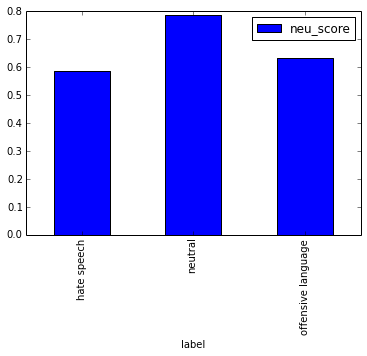

In [46]:
grouped_df.plot(y=['neu_score'], kind='bar')

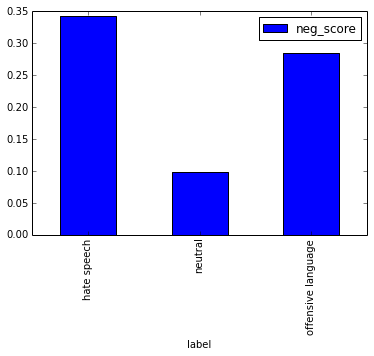

In [47]:
grouped_df.plot(y=['neg_score'], kind='bar')

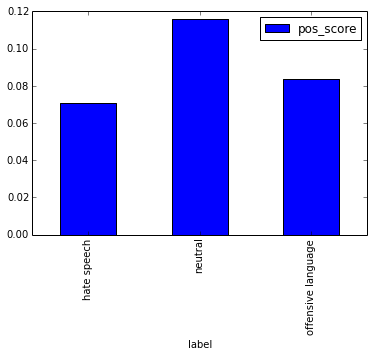

In [48]:
grouped_df.plot(y=['pos_score'], kind='bar')

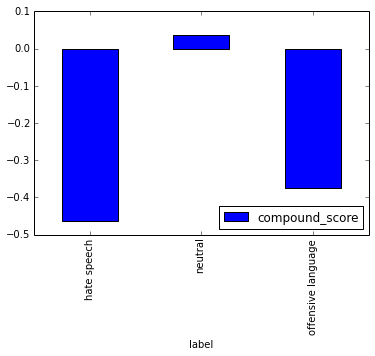

In [49]:
grouped_df.plot(y=['compound_score'], kind='bar')

### Sentiment Analysis results
This looks like it could be quite useful, neutral and negative sentiments seem to quite strongly correlate with their apropriate labels. This simply leaves a need for a way to distinguish between offensive and hateful speech. We can try my trivial list of hateful words. What i have found is the Facebook list of words to block, again this is probably limited to English, but I think it will make a good attempt.